In [ ]:
import spectral.io.envi as envi
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Images

## Import and preview hrHSI

In [ ]:
from preprocessing import preprocessHrHSI

# Specify paths
hr_path = "data/FX10/"
hr_mtx_path = 'data/FX10/2D/hrHSI_matrix.npy'
hr_dist_path = 'data/FX10/2D/hrHSI_dist.npy'

# Load and preprocess file
hr_file = preprocessHrHSI(hr_path + "leaf_test1.hdf5", hr_mtx_path, hr_dist_path)

# Store to variables
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

In [ ]:
from preprocessing import previewHrHSI

# Select pixel and spectrum to highlight
hr_selected_pixel = (650, 650)
hr_selected_spectrum = 120

# Preview
previewHrHSI(hr_img, hr_wavelengths, hr_selected_pixel, hr_selected_spectrum)

## Import and preview snapshot

In [ ]:
from preprocessing import preprocessSnapshot

# Specify paths
ss_path = "data/Snapshot/leaf_test_processed/leaf_test/"
ss_mtx_path = 'data/Snapshot/2D/snapshot_matrix.npy'
ss_dist_path = 'data/Snapshot/2D/snapshot_dist.npy'

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path)

# Store to variables
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]

In [ ]:
from preprocessing import previewSnapshot

# Select pixel and spectrum to highlight
ss_selected_pixel = (75, 210)
ss_selected_spectrum = 20

# Preview
previewSnapshot(ss_img, ss_wavelengths, ss_selected_pixel, ss_selected_spectrum)

## Compare hrHSI and Snapshot

In [1]:
from preprocessing import preprocessHrHSI

# Specify paths
hr_path = "data/FX10/calibration0"
hr_mtx_path = 'data/FX10/2D/hrHSI_matrix.npy'
hr_dist_path = 'data/FX10/2D/hrHSI_dist.npy'

# Load and preprocess file
hr_file = preprocessHrHSI(hr_path + ".hdf5", hr_mtx_path, hr_dist_path)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

In [2]:
from preprocessing import preprocessSnapshot

# Specify paths
ss_path = "data/Snapshot/calibration_processed/calibration0/"
ss_mtx_path = 'data/Snapshot/2D/snapshot_matrix.npy'
ss_dist_path = 'data/Snapshot/2D/snapshot_dist.npy'

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path)
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]

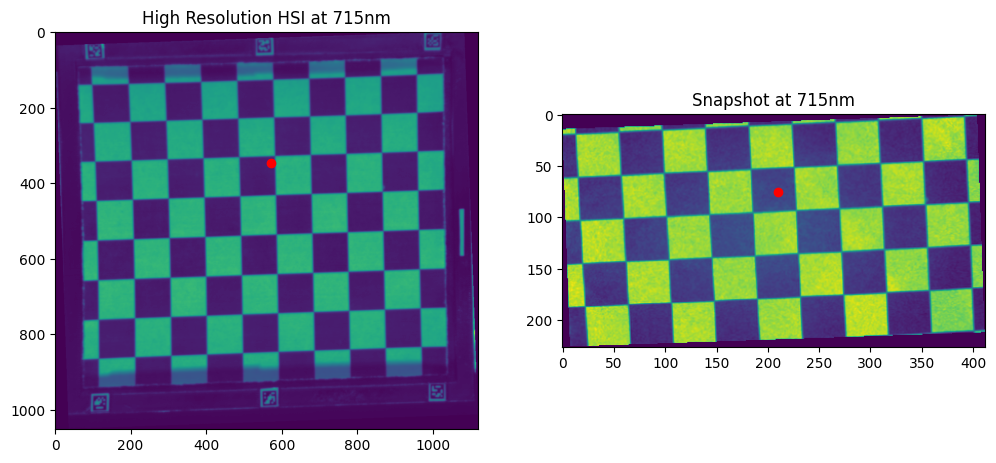

In [4]:
from align_images import align_images, plot_image_comparison

# Set offsets
x_off = (0, 1084)   # Full: (0, 1084)
y_off = (0, 1015)   # Full: (0, 1015)

# Align images
hr_img_al, ss_img_al = align_images(hr_img=hr_img,
                                    ss_img=ss_img, 
                                    x_off=x_off, 
                                    y_off=y_off,
                                    hr_rot=2,
                                    ss_rot=2)

# Plot image comparison
plot_image_comparison(hr_img=hr_img_al, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img_al, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(75, 210),
                      selected_spectrum=715)

In [ ]:
selected_pixel = (75, 210)
selected_spectrum = 715

# Pick closest value to selected spectrum in list of wavelengths
hr_selected_spectrum_index = hr_wavelengths.index(min(hr_wavelengths, key=lambda x:abs(x-selected_spectrum)))
ss_selected_spectrum_index = ss_wavelengths.index(min(ss_wavelengths, key=lambda x:abs(x-selected_spectrum)))

# Crop hrHSI to match snapshot
y_off = (285, 810)
x_off = (95, 1024)
hr_img_cropped = hr_img[y_off[0]:y_off[1], x_off[0]:x_off[1], :]

# Transform selected pixel to scale
scaling = (hr_img_cropped.shape[0] / ss_img.shape[0], hr_img_cropped.shape[1] / ss_img.shape[1])
selected_pixel_scaled = (selected_pixel[0]*scaling[0], selected_pixel[1]*scaling[1])

# Plot hrHSI and snapshot image next to each other
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(hr_img_cropped[:, :, hr_selected_spectrum_index])
plt.plot(selected_pixel_scaled[1], selected_pixel_scaled[0], 'ro')
plt.title('High Resolution HSI' + ' at ' + str(hr_wavelengths[hr_selected_spectrum_index]) + 'nm')
plt.subplot(1, 2, 2)
plt.imshow(ss_img[:, :, ss_selected_spectrum_index])
plt.plot(selected_pixel[1], selected_pixel[0], 'ro')
plt.title('Snapshot' + ' at ' + str(ss_wavelengths[ss_selected_spectrum_index]) + 'nm')
plt.show()

In [ ]:
# Compare the spectral composition of the selected pixel in both images
plt.figure()
plt.plot(hr_wavelengths, hr_img_cropped[int(selected_pixel_scaled[0]), int(selected_pixel_scaled[1]), :])
plt.plot(ss_wavelengths, ss_img_np[selected_pixel[0], selected_pixel[1], :])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Spectral Composition of Pixel ' + str(selected_pixel))
plt.legend(['High Resolution HSI', 'Snapshot'])
plt.axvline(selected_spectrum, color='r', linestyle='-')
plt.show()